In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Cargar y Preprocesar los Datos

In [77]:
# Ruta del archivo corregido
file_path = 'D://Facu/2024/2C/Aprendizaje Automatico/Trabajo final/deteccion_de_estacionalidad_en_crimen/data/external/delitos_correjido.xlsx'
df = pd.read_excel(file_path)

# Renombrar la primera columna para mayor claridad
df.rename(columns={df.columns[0]: 'Tipo de Delito'}, inplace=True)

# Filtrar los nombres actuales de las columnas que contienen datos de meses y años
column_names = df.columns[1:]
mes_anio_columns = []

# Definir los años y meses que vamos a utilizar
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sept', 'oct', 'nov', 'dic']
anios = list(range(2014, 2025))

# Ajustar el proceso de renombrado
anio_index = 0
for i, column in enumerate(column_names):
    if anio_index < len(anios):
        mes = meses[i % len(meses)]
        anio = anios[anio_index]

        mes_anio_columns.append(f"{mes}_{anio}")

        # Incrementar el índice de año cada 12 meses
        if mes == 'dic':
            anio_index += 1
    else:
        break

# Renombrar las columnas de acuerdo con los nuevos nombres generados
df_cleaned = df.copy()
df_cleaned.columns = ['Tipo de Delito'] + mes_anio_columns + list(df.columns[len(mes_anio_columns) + 1:])

# Transformar los datos con 'melt' para obtener un formato largo, incluyendo solo las categorías principales
categorias_principales = ["Contra las Personas", "Otros Delitos Contra las Personas", "Contra la Propiedad"]

data_dict = {}
for categoria in categorias_principales:
    # Seleccionar las filas correspondientes a la categoría principal
    df_categoria = df_cleaned[df_cleaned['Tipo de Delito'] == categoria]
    
    # Transformar los datos para tener una estructura adecuada con 'melt'
    df_melted = df_categoria.melt(id_vars=['Tipo de Delito'], var_name='Mes_Año', value_name='Cantidad')
    
    # Limpiar los datos derretidos: eliminar filas con valores nulos en 'Cantidad'
    df_melted = df_melted.dropna(subset=['Cantidad'])
    
    # Separar la columna 'Mes_Año' en 'Mes' y 'Año'
    df_melted['Año'] = df_melted['Mes_Año'].str.extract(r'(\d{4})$')  # Extraer el año (los últimos 4 caracteres)
    df_melted['Mes'] = df_melted['Mes_Año'].str.extract(r'^(\w+)_')   # Extraer el mes (antes del guion bajo)
    df_melted['Año'] = df_melted['Año'].astype(int)
    
    # Convertir los nombres de los meses a números
    meses_dict = {'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
                  'jul': 7, 'ago': 8, 'sept': 9, 'oct': 10, 'nov': 11, 'dic': 12}
    df_melted['Mes'] = df_melted['Mes'].map(meses_dict)
    
    # Guardar los datos en el diccionario
    data_dict[categoria] = df_melted

# Crear un DataFrame consolidado para análisis con las categorías principales
df_analysis = pd.concat(data_dict.values(), ignore_index=True)

# Reorganizar las columnas para mejor comprensión
df_analysis = df_analysis[['Tipo de Delito', 'Año', 'Mes', 'Cantidad']]

# Crear la columna de fecha con un valor predeterminado para el día (1 de cada mes)
df_analysis['Fecha'] = pd.to_datetime(df_analysis.apply(lambda row: f"{int(row['Año'])}-{int(row['Mes']):02d}-01", axis=1), errors='coerce')
df_analysis.dropna(subset=['Fecha'], inplace=True)

# Verificar duplicados y eliminarlos si es necesario
df_analysis.drop_duplicates(subset=['Fecha', 'Tipo de Delito'], keep='first', inplace=True)

### Gráficos Exploratorios 

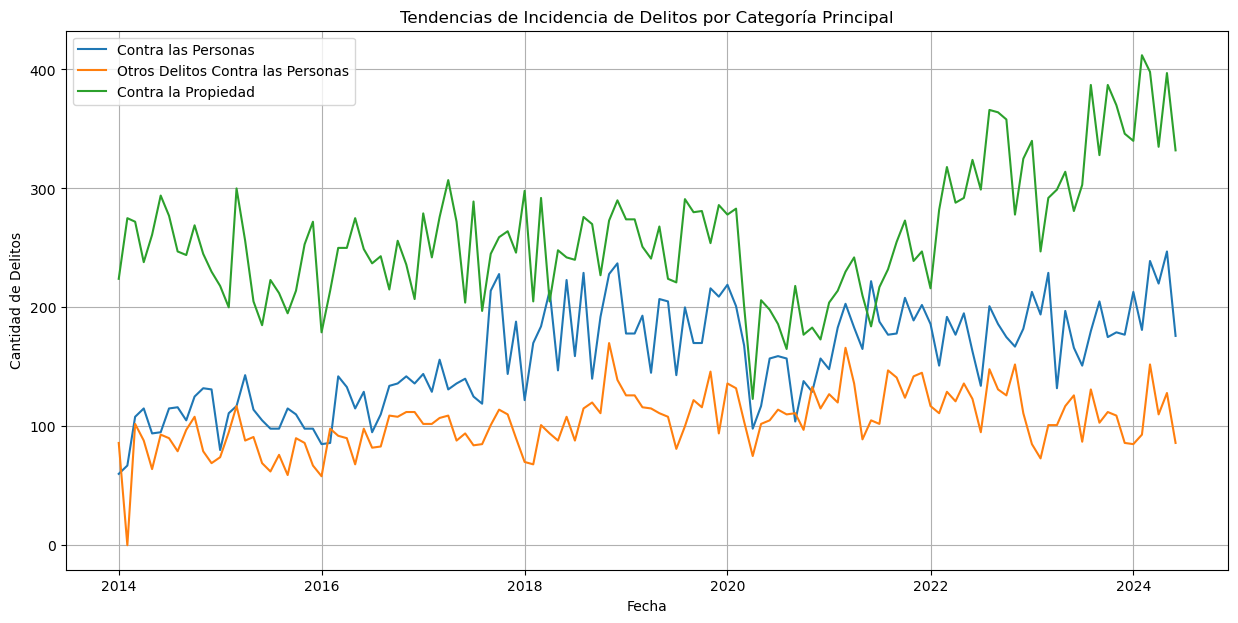

In [61]:
# 1. Tendencias de incidencia de cada delito a lo largo del tiempo
plt.figure(figsize=(15, 7))
for categoria in categorias_principales:
    df_categoria = df_analysis[df_analysis['Tipo de Delito'] == categoria]
    plt.plot(df_categoria['Fecha'], df_categoria['Cantidad'], label=categoria)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Delitos')
plt.title('Tendencias de Incidencia de Delitos por Categoría Principal')
plt.legend()
plt.grid(True)
plt.show()

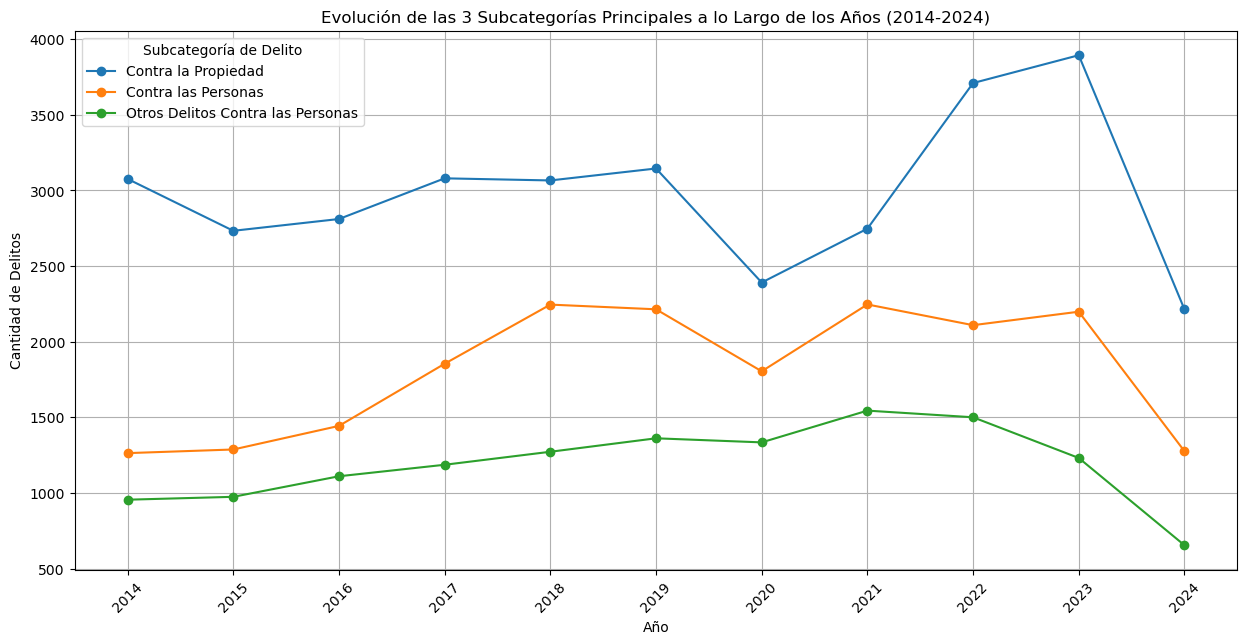

In [69]:
# 2. Evolución de las 3 Subcategorías Principales a lo Largo de los Años (2014-2024)
df_subcategorias_anual = df_analysis.groupby(['Año', 'Tipo de Delito'])['Cantidad'].sum().unstack()
subcategorias_principales = df_subcategorias_anual.sum().sort_values(ascending=False).head(3).index
plt.figure(figsize=(15, 7))
for subcategoria in subcategorias_principales:
    plt.plot(df_subcategorias_anual.index, df_subcategorias_anual[subcategoria], marker='o', label=subcategoria)
plt.xlabel('Año')
plt.ylabel('Cantidad de Delitos')
plt.title('Evolución de las 3 Subcategorías Principales a lo Largo de los Años (2014-2024)')
plt.legend(title='Subcategoría de Delito')
plt.xticks(df_subcategorias_anual.index, rotation=45)
plt.grid(True)
plt.show()

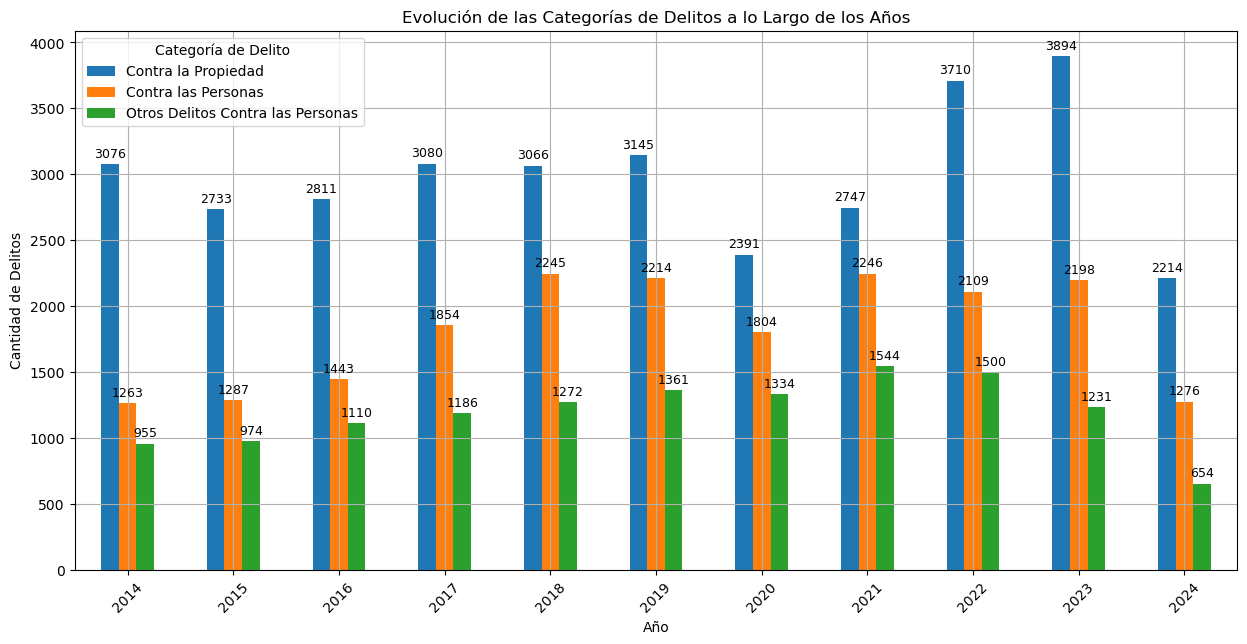

In [71]:
# 3. Evolución de las Categorías de Delitos a lo Largo de los Años (Gráfico de Barras)
df_anual = df_analysis.groupby(['Año', 'Tipo de Delito'])['Cantidad'].sum().unstack()
ax = df_anual.plot(kind='bar', stacked=False, figsize=(15, 7))
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')
plt.xlabel('Año')
plt.ylabel('Cantidad de Delitos')
plt.title('Evolución de las Categorías de Delitos a lo Largo de los Años')
plt.legend(title='Categoría de Delito')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

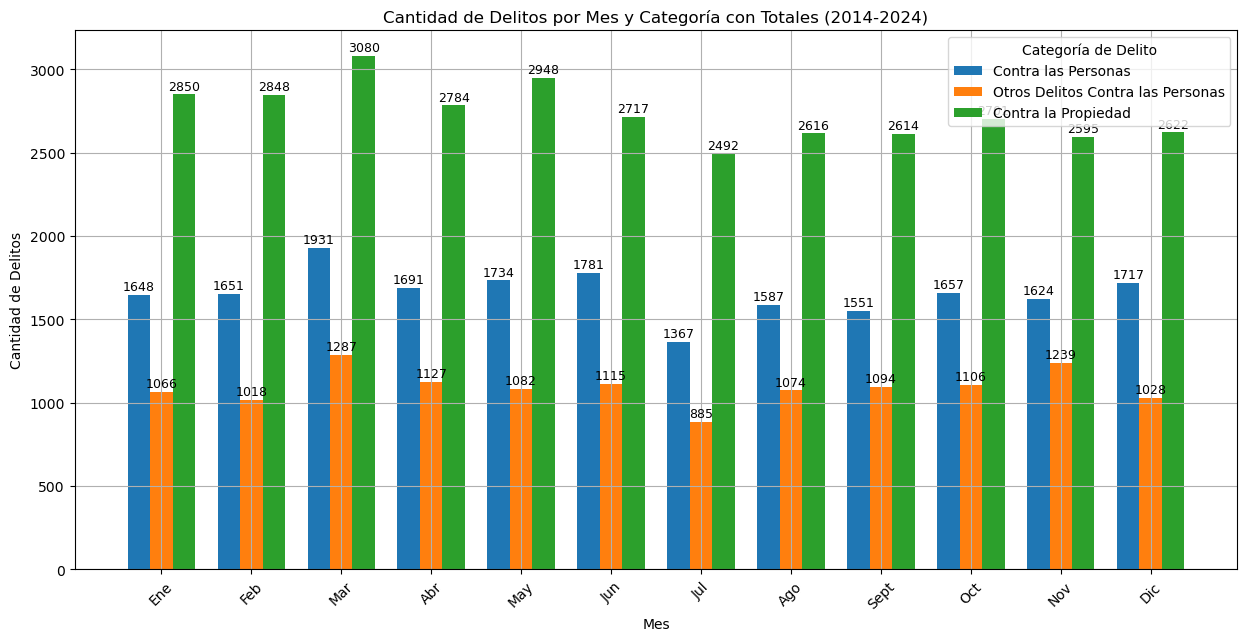

In [73]:
# 4. Gráfico de barras de las categorías por mes con totales para cada categoría
plt.figure(figsize=(15, 7))
bar_width = 0.25
index = np.arange(1, 13)

for i, categoria in enumerate(categorias_principales):
    df_categoria = df_analysis[df_analysis['Tipo de Delito'] == categoria]
    df_mensual_totales = df_categoria.groupby('Mes')['Cantidad'].sum()
    plt.bar(index + i * bar_width, df_mensual_totales, bar_width, label=categoria)
    
    # Agregar anotaciones de los totales en las barras
    for j, total in enumerate(df_mensual_totales):
        plt.text(j + 1 + i * bar_width, total + 10, str(int(total)), ha='center', va='bottom', fontsize=9)

plt.xlabel('Mes')
plt.ylabel('Cantidad de Delitos')
plt.title('Cantidad de Delitos por Mes y Categoría con Totales (2014-2024)')
plt.xticks(ticks=index + bar_width, labels=[mes.capitalize() for mes in meses], rotation=45)
plt.legend(title='Categoría de Delito')
plt.grid(True)
plt.show()


In [75]:
# Análisis estadístico básico (medias, medianas, desviaciones estándar, correlaciones)
# Media, mediana y desviación estándar
estadisticas_basicas = df_analysis.groupby('Tipo de Delito')['Cantidad'].agg(['mean', 'median', 'std'])
print("Análisis Estadístico Básico (Media, Mediana, Desviación Estándar):")
print(estadisticas_basicas)

Análisis Estadístico Básico (Media, Mediana, Desviación Estándar):
                                         mean  median        std
Tipo de Delito                                                  
Contra la Propiedad                260.849206   254.5  53.605084
Contra las Personas                158.246032   158.0  42.589893
Otros Delitos Contra las Personas  104.134921   103.5  24.743275


Matriz de Correlación entre Años y Cantidad de Delitos:
               Año       Mes  Cantidad
Año       1.000000 -0.071415  0.280574
Mes      -0.071415  1.000000  0.031031
Cantidad  0.280574  0.031031  1.000000


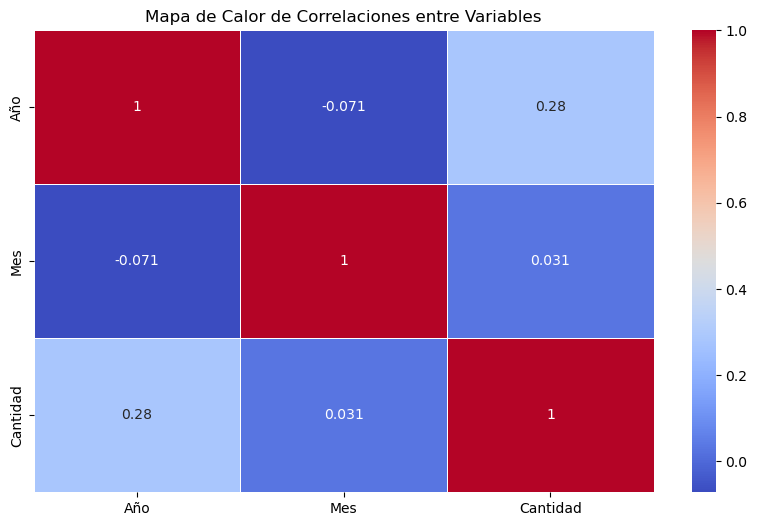

In [79]:
# Matriz de correlación
print("Matriz de Correlación entre Años y Cantidad de Delitos:")
correlacion = df_analysis[['Año', 'Mes', 'Cantidad']].corr()
print(correlacion)

plt.figure(figsize=(10, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones entre Variables')
plt.show()